In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import network
import dataloader as dl
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [3]:
Tokenizer = dl.Tokenizer()

In [4]:
Tokenizer.addWord(" ")
Tokenizer.addWord("ham")
Tokenizer.addWord("spam")
train_dataset = dl.SpamData('train.csv', Tokenizer, 180)
Tokenizer = train_dataset.get()
test_dataset = dl.SpamData('test.csv', Tokenizer, 180)
Tokenizer = test_dataset.get()

In [5]:
train_data = DataLoader(train_dataset, 64, True)
test_data = DataLoader(train_dataset, 64)

In [17]:
from collections import Counter

train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

print("Train data distribution:", Counter(train_labels))
print("Test data distribution:", Counter(test_labels))


Train data distribution: Counter({0: 4825, 1: 747})
Test data distribution: Counter({0: 970, 1: 145})


In [6]:
model = network.Network().to(device)

In [7]:
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3)

In [19]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    losses = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        losses += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch completed. Avg loss: {losses/len(dataloader):>8f}")  
    return losses/len(dataloader)

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss

In [14]:
def using(model, data):
    model.eval()
    with torch.no_grad():
        data.to(device)
        pred = model(data)
        # return pred
        return Tokenizer.Idx2Word(pred.argmax().item())

Epoch 1 is started!
Epoch completed. Avg loss: 1.518505
Test Error: 
 Accuracy: 84.0%, Avg loss: 1.479771


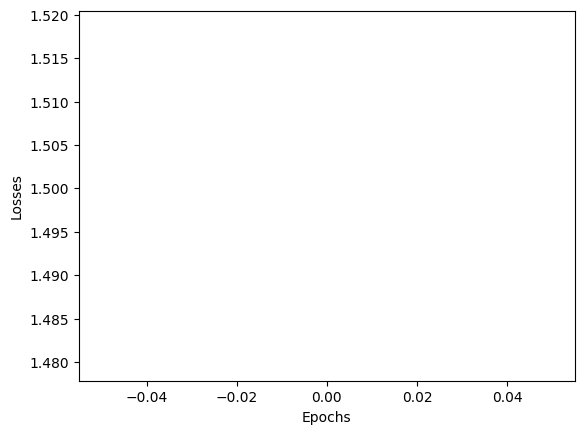

In [21]:
epochs = 5
test_losses = []
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} is started!")
    train_losses.append(train(train_data, model, loss_fn, optimizer))
    test_losses.append(test(test_data, model, loss_fn))
# Проверка значений потерь

# print(test_losses)
plt.plot(train_losses, 'r')
plt.plot(test_losses, 'g')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.show()

In [16]:
import re
text = [0] * 180
pattern = r'[^a-zA-Z0-9\s]'
text_tmp1 = "Hi Akiro, it’s been a while! Let’s grab coffee next week and catch up. Let me know your availability. Looking forward to it! Best, FordMerding"
text_tmp2 = "Congratulations! You've won a $1,000 gift card. Click here to claim your reward. Act fast, this offer expires soon!"
text_tmp = re.sub(pattern, '', text_tmp1)
text_tmp = text_tmp.split()
for i in range(len(text_tmp)):
    text[i] = Tokenizer.Word2Idx(text_tmp[i])
text = torch.tensor(text, dtype=torch.float)    
using(model, text)

tensor([-0.0134, -4.3170])